In [ ]:

#Install Detectron2 from the source
!pip install 'git+https://github.com/facebookresearch/detectron2.git'

In [1]:
#Set up directory and mounting from GDrive
import os
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
#import libraries
import glob
import json
import os
import cv2
import numpy as np
import torch
print(torch.__version__)
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.structures import BoxMode


2.4.0+cu121


In [3]:
#install Google Earth Engine API
!pip install earthengine-api

In [4]:
import ee
ee.Authenticate()
ee.Initialize(project = 'southern-bonsai-435419-q2')

In [14]:



#Mareb
longitude = 45.230503
latitude = 15.376969
bufferzone = 2000

# #Video description
descrip = 'Mareb_dam_landsat'

# Date range if landsat
start_date = '1984-01-01'
end_date = '2022-12-31'



#if sentinel
# start_date = '2015-06-23'  # Sentinel-2 operation start
# end_date = '2022-12-31'

# #Video description
# descrip = 'Mareb_dam_sentinel'


## Landsat Images

In [ ]:
#adapted from https://github.com/csaybar/EEwPython/blob/master/10_Export.ipynb

import ee
import time

# Initialize the Earth Engine API
ee.Initialize()
#12.7049566, 53.5039470
# Define the geographic location and buffer
#Mareb
#longitude = 45.230503
#latitude = 15.376969

#Socotra
# longitude = 53.5039470
# latitude = 12.7049566


#Wadi Wajar Abyan
# longitude = 46.156746
# latitude = 13.941848

point = ee.Geometry.Point([longitude, latitude])
buffered_point = point.buffer(bufferzone).bounds()
region = buffered_point.bounds()



# Date range
# start_date = '1984-01-01'
# end_date = '2022-12-31'

# Load and merge the updated image collections using Collection 2 data
landsat5 = ee.ImageCollection('LANDSAT/LT05/C02/T1_TOA').filterDate('1984-01-01', '2012-05-05')
landsat7 = ee.ImageCollection('LANDSAT/LE07/C02/T1_TOA').filterDate('1999-01-01', '2022-12-31')
landsat8 = ee.ImageCollection('LANDSAT/LC08/C02/T1_TOA').filterDate('2013-01-01', '2022-12-31')
full_collection = landsat5.merge(landsat7).merge(landsat8)




# Filter out images with more than 20% cloud cover
cloud_filtered_collection = full_collection.filter(ee.Filter.lt('CLOUD_COVER', 10))

# Function to scale and cast images
def scale_and_cast(image):
    return image.multiply(255).byte()  # Scale and convert to uint8

# Apply the function to each image in the collection
filtered_collection = full_collection.filterBounds(region).select(['B4', 'B3', 'B2']).map(scale_and_cast)

# Create and start the video export task
task = ee.batch.Export.video.toDrive(**{
    'collection': filtered_collection,
    'description': descrip,
    'dimensions': 720,
    'framesPerSecond': 10,
    'region': region.coordinates().getInfo(),
    'folder': 'videosIn',
    #'scale': 5,
    'maxFrames': 10000  # Increase the maxFrames as needed
})
task.start()

# Monitor the task
while task.active():
    print('Polling for task (id: {}).'.format(task.id))
    time.sleep(10)  # Sleep for 10 seconds before polling again

print("Video export complete.")


 ### Only using two periods of landsat

In [ ]:
#adapted from https://github.com/csaybar/EEwPython/blob/master/10_Export.ipynb

import ee
import time

# Initialize the Earth Engine API
ee.Initialize()
12.7049566, 53.5039470
# Define the geographic location and buffer
#Mareb
#longitude = 45.230503
#latitude = 15.376969

#Socotra
# longitude = 53.5039470
# latitude = 12.7049566


#Wadi Wajar Abyan
# longitude = 46.156746
# latitude = 13.941848

point = ee.Geometry.Point([longitude, latitude])
buffered_point = point.buffer(bufferzone).bounds()
region = buffered_point.bounds()



# Date range
# start_date = '1999-01-01'
# end_date = '2022-12-31'

# Load and merge the updated image collections using Collection 2 data

landsat7 = ee.ImageCollection('LANDSAT/LE07/C02/T1_TOA').filterDate('1999-01-01', '2022-12-31')
landsat8 = ee.ImageCollection('LANDSAT/LC08/C02/T1_TOA').filterDate('2013-01-01', '2022-12-31')
full_collection = landsat7.merge(landsat8)




# Filter out images with more than 50% cloud cover
cloud_filtered_collection = full_collection.filter(ee.Filter.lt('CLOUD_COVER', 20))

# Function to scale and cast images
def scale_and_cast(image):
    return image.multiply(255).byte()  # Scale and convert to uint8

# Apply the function to each image in the collection
filtered_collection = full_collection.filterBounds(region).select(['B4', 'B3', 'B2']).map(scale_and_cast)

# Create and start the video export task
task = ee.batch.Export.video.toDrive(**{
    'collection': filtered_collection,
    'description': descrip,
    'dimensions': 720,
    'framesPerSecond': 10,
    'region': region.coordinates().getInfo(),
    'folder': 'VideosIn',
    'scale': 10,
    'maxFrames': 10000  # Increase the maxFrames as needed
})
task.start()

# Monitor the task
while task.active():
    print('Polling for task (id: {}).'.format(task.id))
    time.sleep(10)  # Sleep for 10 seconds before polling again

print("Video export complete.")


## Sentinel-2 images

In [ ]:
import ee
import time

# Initialize the Earth Engine API
ee.Initialize()

# Define the geographic location and buffer
# longitude = 46.156746
# latitude = 13.941848

# video_name = 'Abyan3_Sentinel2'

point = ee.Geometry.Point([longitude, latitude])
buffered_point = point.buffer(bufferzone).bounds()  # Define a 2km buffer around the point
region = buffered_point.bounds()

# Date range
# start_date = '2015-06-23'  # Sentinel-2 operation start
# end_date = '2022-12-31'

# Load Sentinel-2 ImageCollection
collection = ee.ImageCollection('COPERNICUS/S2') \
    .filterDate(start_date, end_date) \
    .filterBounds(region) \
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 10))  # Filter images based on cloud cover

# Select the RGB bands and scale
def prepare_image(image):
    return image.visualize(bands=['B4', 'B3', 'B2'], max=3000).clip(region)

# Apply the function to each image in the collection
prepared_collection = collection.map(prepare_image)

# Create and start the video export task
task = ee.batch.Export.video.toDrive(**{
    'collection': prepared_collection,
    'description': descrip,
    'dimensions': 720,
    'framesPerSecond': 10,
    'region': region.coordinates().getInfo(),
    'folder': 'VideosIn',
    'maxFrames': 10000
})
task.start()

# Monitor the task
while task.active():
    print('Polling for task (id: {})'.format(task.id))
    time.sleep(10)  # Sleep for 10 seconds before polling again

print("Video export complete.")

## Loading the model

In [ ]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

from detectron2 import model_zoo
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2.data import build_detection_test_loader, MetadataCatalog, DatasetCatalog
from detectron2.data.datasets import register_coco_instances
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg

# Register the dataset only if it's not already registered
#dataset_name = "waterbodies_test"


def get_waterbodies_dicts(img_dir, annotations_json):
    json_file = os.path.join(img_dir, annotations_json)
    with open(json_file) as f:
        imgs_anns = json.load(f)

    dataset_dicts = []
    for idx, v in enumerate(imgs_anns['images']):
        record = {}
        filename = os.path.join(img_dir, v['file_name'])
        height, width = cv2.imread(filename).shape[:2]

        record["file_name"] = filename
        record["image_id"] = idx
        record["height"] = height
        record["width"] = width

        annos = [anno for anno in imgs_anns['annotations'] if anno['image_id'] == v['id']]
        objs = []
        for anno in annos:
            obj = {
                "bbox": anno['bbox'],
                "bbox_mode": BoxMode.XYWH_ABS,
                "segmentation": anno['segmentation'],
                "category_id": anno['category_id'],
            }
            objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts

# Paths to the train and test annotation files

# Register the datasets
# Paths to the train and test annotation files
annotation_file_test = '/content/drive/MyDrive/Project/annotations_test.json'
annotation_file_train = '/content/drive/MyDrive/Project/annotations_train.json'

# Register the datasets
DatasetCatalog.register("waterbodies_train", lambda: get_waterbodies_dicts("/content/drive/MyDrive/Project/images/", annotation_file_train))
MetadataCatalog.get("waterbodies_train").set(thing_classes=["waterbody"])

DatasetCatalog.register("waterbodies_test", lambda: get_waterbodies_dicts("/content/drive/MyDrive/Project/images/", annotation_file_test))
MetadataCatalog.get("waterbodies_test").set(thing_classes=["waterbody"])




# Initialize model
cfg = get_cfg()

cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.WEIGHTS = "/content/drive/MyDrive/Project/model_final.pth"

#threshold for predictions
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1
cfg.DATASETS.TEST = ("waterbodies_test",)
cfg.DATASETS.TRAIN = ("waterbodies_train",)  # Make sure no default COCO dataset is referenced
cfg.DATASETS.VAL = ("waterbodies_test",)  # Make sure no default COCO dataset is referenced
# cfg.INPUT.MIN_SIZE_TRAIN = (512,)  # Only one size, no choice needed
# cfg.INPUT.MIN_SIZE_TRAIN_SAMPLING = "choice"
# cfg.INPUT.MAX_SIZE_TRAIN = 512  # No need to allow any larger sizes
# cfg.INPUT.MIN_SIZE_TEST = 512  # Same as training
# cfg.INPUT.MAX_SIZE_TEST = 512  # Same as training
# Setting up the test data loader and evaluator
val_loader = build_detection_test_loader(cfg, "waterbodies_test")
evaluator = COCOEvaluator("waterbodies_test", cfg, False, output_dir="/content/drive/MyDrive/Project/output/")


trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=True)
# results = inference_on_dataset(trainer.model, val_loader, evaluator)
# print(results)
predictor = DefaultPredictor(cfg)

## Importing exported video from GDrive

In [18]:
#adapted from https://stackoverflow.com/questions/60663073/how-can-i-properly-run-detectron2-on-videos

import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()
# Import necessary libraries
import numpy as np
import tqdm
import cv2
import pandas as pd
import time
# Import detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.video_visualizer import VideoVisualizer
from detectron2.utils.visualizer import ColorMode
from detectron2.data import MetadataCatalog


# Extract video properties
video = cv2.VideoCapture(('/content/drive/MyDrive/VideosIn/' + descrip + '.mp4'))
width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))
frames_per_second = video.get(cv2.CAP_PROP_FPS)
num_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))

# Initialize video writer
video_writer = cv2.VideoWriter(
    ('/content/drive/MyDrive/VideosOut/' + descrip + '.mp4'),
    fourcc=cv2.VideoWriter_fourcc(*"mp4v"),
    fps=float(frames_per_second),
    frameSize=(width, height),
    isColor=True,
)

# Initialize visualizer
metadata = MetadataCatalog.get(cfg.DATASETS.TRAIN[0])
v = VideoVisualizer(metadata, ColorMode.IMAGE)

def runOnVideo(video, maxFrames):
    """Runs the predictor on every frame in the video (up to maxFrames),
    and yields the frame index, visualization, and predicted water pixel count.
    """
    readFrames = 0
    while True:
        hasFrame, frame = video.read()
        if not hasFrame:
            break

        # Get prediction results for this frame
        outputs = predictor(frame)

        # Get predicted masks
        pred_masks = outputs['instances'].pred_masks.cpu().numpy()
        if pred_masks.size == 0:
            predicted_mask = np.zeros((frame.shape[0], frame.shape[1]), dtype=np.uint8)
        else:
            predicted_mask = (np.sum(pred_masks, axis=0) >= 1).astype(np.uint8) * 255

        # Count the number of pixels in the predicted mask
        predicted_water_pixels = np.sum(predicted_mask == 255)

        # Draw a visualization of the predictions using the video visualizer
        visualization = v.draw_instance_predictions(frame, outputs["instances"].to("cpu"))

        # Convert Matplotlib RGB format to OpenCV BGR format
        visualization = cv2.cvtColor(visualization.get_image(), cv2.COLOR_RGB2BGR)

        yield readFrames, visualization, predicted_water_pixels

        readFrames += 1
        if readFrames >= maxFrames:
            break

# Initialize a list to store results
results = []

# Enumerate the frames of the video
for frame_idx, visualization, predicted_water_pixels in tqdm.tqdm(runOnVideo(video, num_frames), total=num_frames):
    # Write test image (optional)
    if frame_idx == 0:
        cv2.imwrite('/content/drive/MyDrive/VideosOut/TEST_detectron2.png', visualization)

    # Write to video file
    video_writer.write(visualization)

    # Collect results
    results.append({'frame_index': frame_idx, 'predicted_water_pixels': predicted_water_pixels})

# Release resources
video.release()
video_writer.release()
cv2.destroyAllWindows()

# Create a dataframe from the results and save to CSV
df = pd.DataFrame(results)
df.to_csv(('/content/drive/MyDrive/VideosOut/Data/predicted_water_pixel_counts' + descrip + '.csv'), index=False)
print(df)


100%|██████████| 854/854 [03:58<00:00,  3.58it/s]

     frame_index  predicted_water_pixels
0              0                  350802
1              1                  338575
2              2                  336893
3              3                  358083
4              4                  325929
..           ...                     ...
849          849                  400229
850          850                  396810
851          851                  395456
852          852                  389864
853          853                  388777

[854 rows x 2 columns]


## visualise the change over time in terms of predicted pixels

### First let's do the raw data

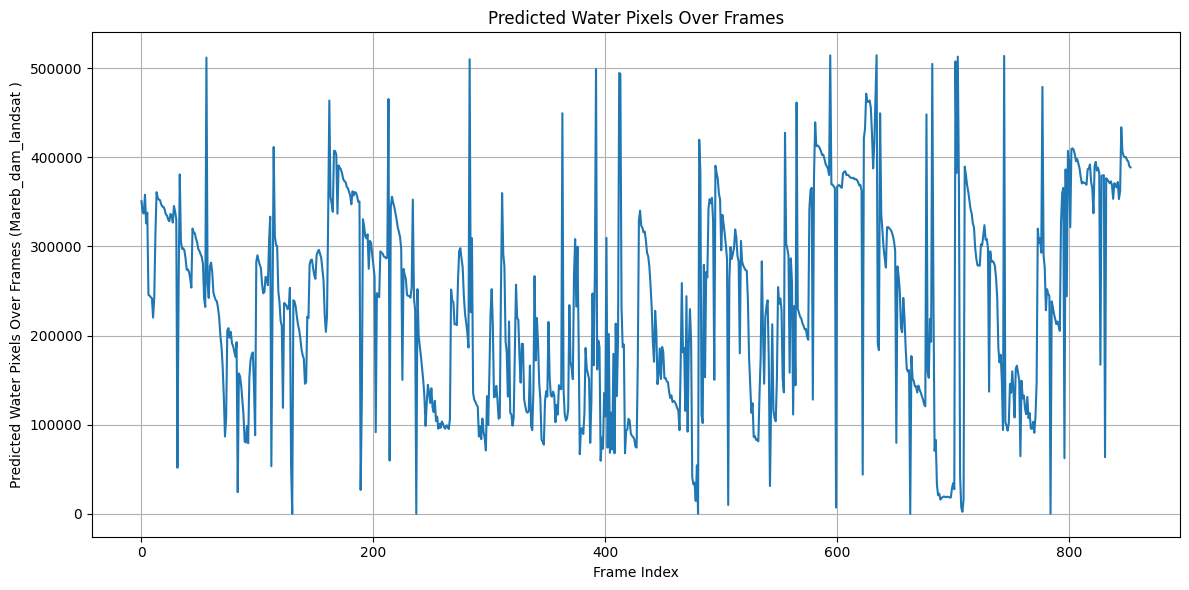

In [35]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data (assuming you have saved it to a CSV file)
df = pd.read_csv(('/content/drive/MyDrive/VideosOut/Data/predicted_water_pixel_counts' + descrip + '.csv'))

# Plotting the data
plt.figure(figsize=(12, 6))
plt.plot(df['frame_index'], df['predicted_water_pixels'])
plt.title('Predicted Water Pixels Over Frames')
plt.xlabel('Frame Index')
plt.ylabel(('Predicted Water Pixels Over Frames ('+ descrip+' )' ))
plt.grid(True)
plt.tight_layout()
# Save the plot as a JPEG
plt.savefig(('/content/drive/MyDrive/VideosOut/Plots/predicted_water_pixel_counts_' + descrip + '_original.jpg'), format='jpg')
plt.show()


### Let's plot it while removing the outliers

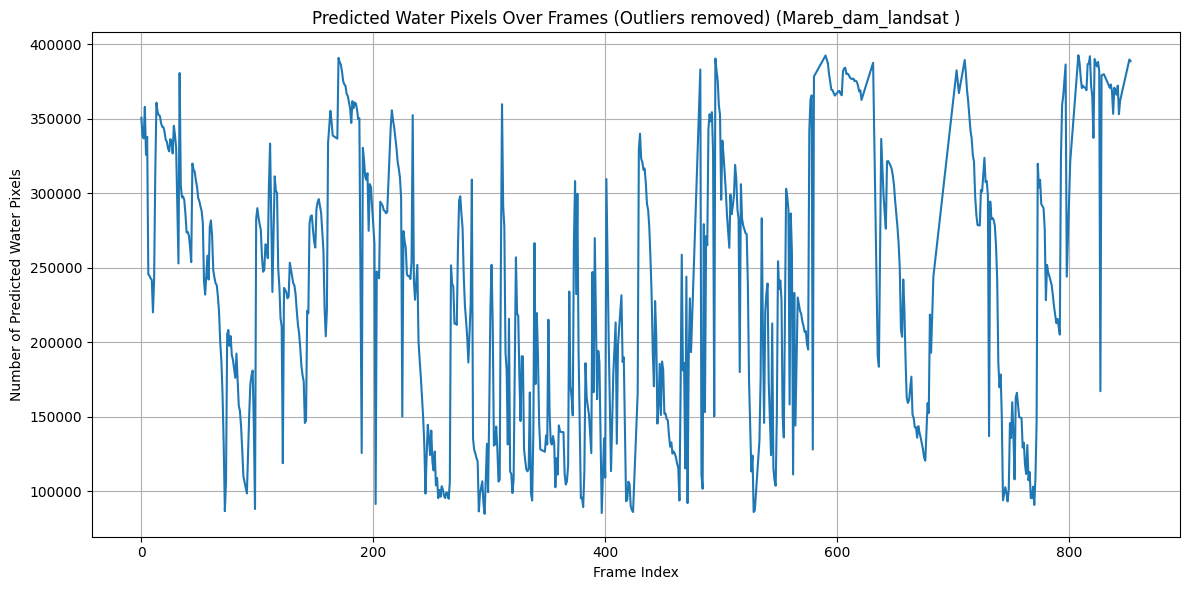

In [36]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data
df = pd.read_csv(('/content/drive/MyDrive/VideosOut/Data/predicted_water_pixel_counts' + descrip + '.csv'))

# Calculate Q1 (25th percentile) and Q3 (75th percentile)
Q1 = df['predicted_water_pixels'].quantile(0.40)
Q3 = df['predicted_water_pixels'].quantile(0.60)
IQR = Q3 - Q1

# Define the bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out the outliers
df_no_outliers = df[(df['predicted_water_pixels'] >= lower_bound) & (df['predicted_water_pixels'] <= upper_bound)]

# Plotting the data without outliers
plt.figure(figsize=(12, 6))
plt.plot(df_no_outliers['frame_index'], df_no_outliers['predicted_water_pixels'])
plt.title(('Predicted Water Pixels Over Frames (Outliers removed) ('+ descrip+' )' ))
plt.xlabel('Frame Index')
plt.ylabel('Number of Predicted Water Pixels')
plt.grid(True)
plt.tight_layout()
# Save the plot as a jpg file
plt.savefig(('/content/drive/MyDrive/VideosOut/Plots/predicted_water_pixel_counts_' + descrip + '_outliers_removed.jpg'), format='jpg')
plt.show()


### Using a Savitzky-Golay filter

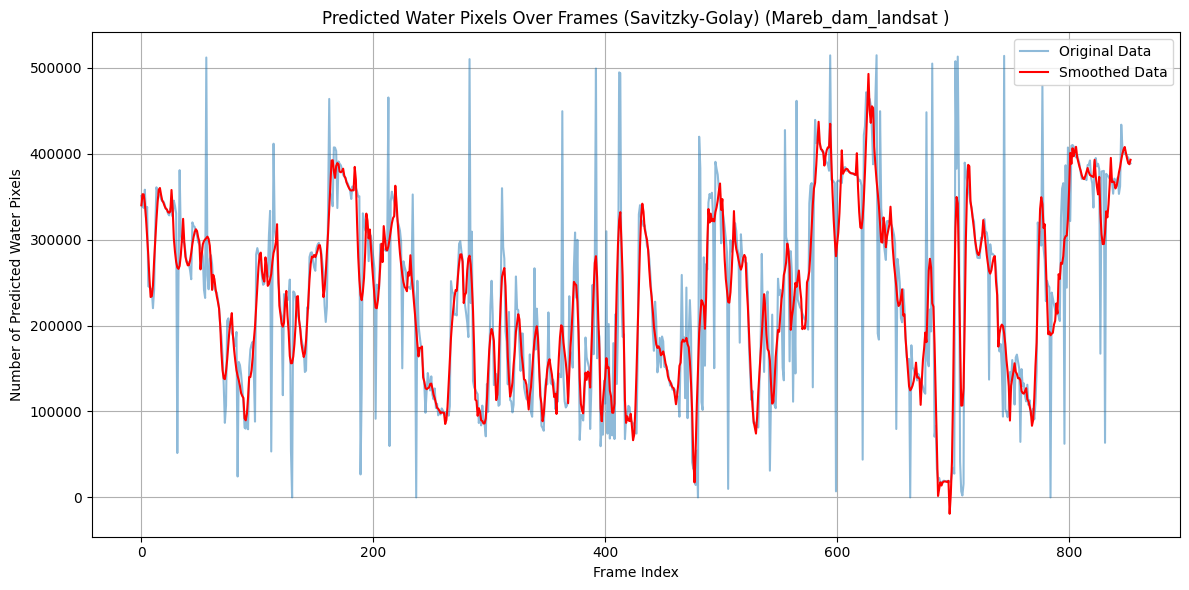

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

# Load the data
df = pd.read_csv(('/content/drive/MyDrive/VideosOut/Data/predicted_water_pixel_counts' + descrip + '.csv'))

# Apply Savitzky-Golay filter for smoothing
window_size = 11  # Window size must be odd and greater than poly_order
poly_order = 3    # Polynomial order
df['smoothed_pixels'] = savgol_filter(df['predicted_water_pixels'], window_size, poly_order)

# Plotting the original and smoothed data
plt.figure(figsize=(12, 6))
plt.plot(df['frame_index'], df['predicted_water_pixels'], label='Original Data', alpha=0.5)
plt.plot(df['frame_index'], df['smoothed_pixels'], label='Smoothed Data', color='red')
plt.title(('Predicted Water Pixels Over Frames (Savitzky-Golay) ('+ descrip+' )' ))
plt.xlabel('Frame Index')
plt.ylabel('Number of Predicted Water Pixels')
plt.legend()
plt.grid(True)
plt.tight_layout()
# Save the plot as a jpg
plt.savefig(('/content/drive/MyDrive/VideosOut/Plots/predicted_water_pixel_counts_' + descrip + '_savitzky-golay.jpg'), format='jpg')
plt.show()


### Moving Average!!

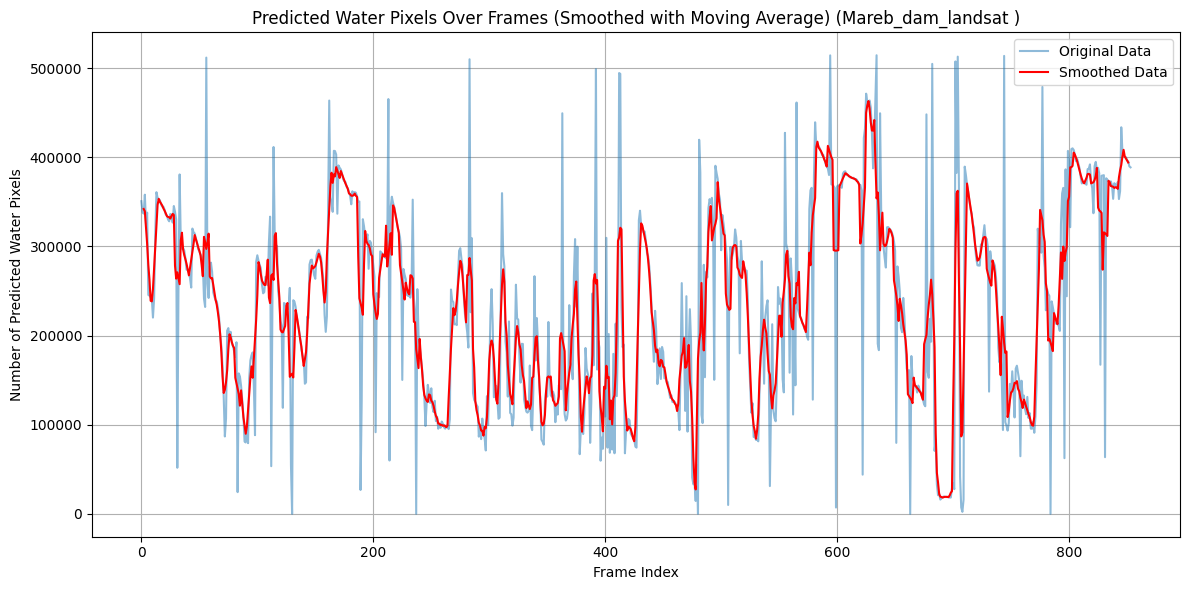

In [38]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data
df = pd.read_csv(('/content/drive/MyDrive/VideosOut/Data/predicted_water_pixel_counts' + descrip + '.csv'))

# Apply a moving average for smoothing
window_size = 5  # Adjust the window size as needed
df['smoothed_pixels'] = df['predicted_water_pixels'].rolling(window=window_size, center=True).mean()

# Plotting the original and smoothed data
plt.figure(figsize=(12, 6))
plt.plot(df['frame_index'], df['predicted_water_pixels'], label='Original Data', alpha=0.5)
plt.plot(df['frame_index'], df['smoothed_pixels'], label='Smoothed Data', color='red')
plt.title(('Predicted Water Pixels Over Frames (Smoothed with Moving Average) ('+ descrip+' )' ))
plt.xlabel('Frame Index')
plt.ylabel('Number of Predicted Water Pixels')
plt.legend()
plt.grid(True)
plt.tight_layout()
# Save the plot as a jpg
plt.savefig(('/content/drive/MyDrive/VideosOut/Plots/predicted_water_pixel_counts_' + descrip + '_moving average.jpg'), format='jpg')
plt.show()
